In [ ]:
#Work Inspired by Andrew Udell in the article “Creating A Snapchat-Style Filter with Python”

In [ ]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Import the pre-trained models for face and eye detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [ ]:
# Global variable to cache the location of eyes
eye_cache = None

In [ ]:
# Turned off videoCapture by adjusting parameter to zero
# Passing a zero, tells the computer to use the 0th camera (none)
cap = cv2.VideoCapture(0)

In [ ]:
# Add locally hosted images through postimage.org 
# Linked here: https://postimages.org/

# Sunglasses photo
!wget https://firebasestorage.googleapis.com/v0/b/dbach-fitness.appspot.com/o/sunglasses.png?alt=media&token=89f1d475-1f0c-4792-8c20-1040eb6273bd -O sunglasses.png

# Our photos
!wget https://i.postimg.cc/RFP7thPv/66045036268-044-A016-F-DCE0-487-D-8-F70-3-A0-DE944-AD8-C.jpg -O jetta.jpg
!wget https://i.postimg.cc/XNCmwyM2/IMG-2959.jpg -O jax.png

/bin/bash: -O: command not found
--2021-12-20 21:24:42--  https://firebasestorage.googleapis.com/v0/b/dbach-fitness.appspot.com/o/sunglasses.png?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 173.194.216.95, 2607:f8b0:400c:c03::5f
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|173.194.216.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159133 (155K) [image/png]
Saving to: ‘sunglasses.png?alt=media.2’

sunglasses.png?alt= 100%[===================>] 155.40K  --.-KB/s    in 0.005s  

2021-12-20 21:24:43 (31.4 MB/s) - ‘sunglasses.png?alt=media.2’ saved [159133/159133]

--2021-12-20 21:24:43--  https://i.postimg.cc/RFP7thPv/66045036268-044-A016-F-DCE0-487-D-8-F70-3-A0-DE944-AD8-C.jpg
Resolving i.postimg.cc (i.postimg.cc)... 172.93.106.42
Connecting to i.postimg.cc (i.postimg.cc)|172.93.106.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91684 (90K) [image/jpeg]
Sa

In [ ]:
frame = imageio.imread('jax.png') 

In [ ]:
# Convert to grayscale
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

In [ ]:
print(faces)

[[ 27 193 331 331]]


In [ ]:
for (x,y,w,h) in faces:
  # Draw a rectangle around the face
  roi_gray = gray_frame[y:y+h, x:x+w]
  # Detect eyes within the grayscale region of interest
  eyes = eye_cascade.detectMultiScale(roi_gray)

In [ ]:
# Only detect 2 eyes
if len(eyes) == 2:
  # Store the position of the eyes in cache
  eye_cache = eyes
# If 2 eyes aren't detected, use the eye cache
elif eye_cache is not None:
  eyes = eye_cache

In [ ]:
# read the sunglasses image and get dimensions
# take note that if you get an error 
# make sure the name for sunglasses has the correct version within ""
img = cv2.imread("sunglasses.png?alt=media.3")
img_h = img.shape[0] * 1.5
img_w = img.shape[1] * 1.5
# Create source matrix
src_mat = np.array([[0,0], [img_w, 0],  [img_w, img_h], [0, img_h]])

AttributeError: ignored

In [ ]:
# define the destination matrix based on eye detected order.
# Order of points must be top-left, top-right, bottom-left,
# and bottom-right
if eyes[0][0] < eyes[1][0]:
    dst_mat = np.array([
        [x + eyes[0][0], y + eyes[0][1]],
        [x + eyes[1][0] + eyes[1][2], y + eyes[1][2]],
        [x + eyes[1][0] + eyes[1][2], y + eyes[1][1] + eyes[1][3]],
        [x + eyes[0][0], y + eyes[0][1] + eyes[0][3]]
    ])
else:
    dst_mat = np.array([
        [x + eyes[1][0], y + eyes[1][1]],
        [x + eyes[0][0] + eyes[0][2], y + eyes[0][2]],
        [x + eyes[0][0] + eyes[0][2], y + eyes[0][1] + eyes[1][3]],
        [x + eyes[1][0], y + eyes[1][1] + eyes[1][3]]
    ])

In [ ]:
# Get the dimensions of the frame
face_height = frame.shape[0]
face_width = frame.shape[1]
# Find the Homography matrix
homography = cv2.findHomography(src_mat, dst_mat)[0]
# Warp the image to fit the homegraphy matrix
warped = cv2.warpPerspective(img, homography, (face_width, face_height))

In [ ]:
# Grab the alpha channel of the warped image and create a mask
mask = warped[:,:,2]
# Copy and convert the mask to a float and give it 3 channels
mask_scale = mask.copy() / 255.0
mask_scale = np.dstack([mask_scale] * 3)
# Remove the alpha channel from the warped image
warped = cv2.cvtColor(warped, cv2.COLOR_BGRA2BGR)

In [ ]:
warped_multiplied = cv2.multiply(mask_scale, warped.astype("float"))
image_multiplied = cv2.multiply(frame.astype(float), 1.0 - mask_scale)
output = cv2.add(warped_multiplied, image_multiplied)
output = output.astype("uint8")

Sunglasses overlay


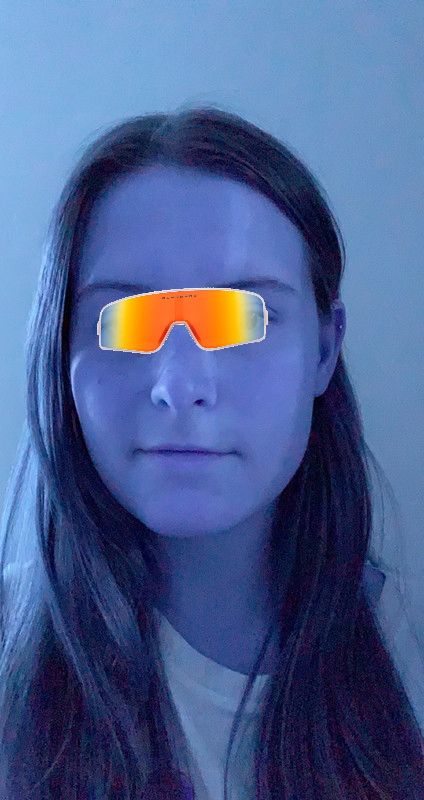

In [ ]:
print("Sunglasses overlay")
cv2_imshow(output)